In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv


In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
import csv
import os

# Prepare Data

## Import

In [4]:
# Write a wrangle function

def wrangle(filepath):
    # Read csv files into DataFrame
    df=pd.read_csv(filepath)
    
    # Subset to properties in Distrito Federal
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    
    # Subset to apartment
    mask_apt=df["property_type"]=="apartment"
    
    # Subset to properties where price usd <4000_000
    mask_price=df["price_aprox_usd"] < 4000_000
    # Subset
    df=df[mask_ba & mask_apt & mask_price]
    
    # Remove outliers by "surface_covered_in_m2"
    low, high=df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area=df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]
    
    return df

In [5]:
# Use wrangle function to create a DataFrame from df

df = wrangle("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv")
df.drop(columns=["Unnamed: 0"],inplace=True)
print("df shape:", df.shape)

df.head()

df shape: (2107, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
2,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.389011,-99.180415",1000000.0,MXN,990953.65,52686.48,NaN,65.0,NaN,15384.615380,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/n36r_ven...
3,sell,apartment,|Iztacalco|Distrito Federal|México|,"23.634501,-102.552788",922096.0,MXN,913754.35,48581.99,NaN,66.0,NaN,13971.151520,NaN,NaN,NaN,http://iztacalco.properati.com.mx/p2qv_venta_d...
6,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,"19.469681,-99.086136",1150000.0,MXN,1139596.67,60589.45,NaN,52.0,NaN,22115.384620,NaN,NaN,NaN,http://san-juan-de-aragon.properati.com.mx/oi9...
8,sell,apartment,|Cuauhtémoc|Distrito Federal|México|,"19.429437,-99.14346",636418.0,MXN,630660.66,33530.62,NaN,69.0,NaN,9223.449275,NaN,NaN,NaN,http://cuauhtemoc.properati.com.mx/pfui_venta_...
11,sell,apartment,|Iztacalco|Distrito Federal|México|,"19.408007,-99.069186",443290.0,MXN,439279.85,23355.39,NaN,54.0,NaN,8209.074074,NaN,NaN,NaN,http://iztacalco.properati.com.mx/q7n2_venta_d...


# Explore

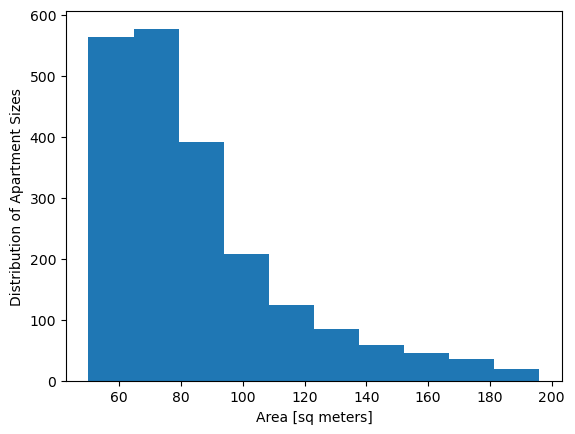

In [6]:
#Create a histogram of "surface_covered_in_m2"

plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Distribution of Apartment Sizes");

In [7]:
df["surface_covered_in_m2"].describe()

count    2107.000000
mean       84.365923
std        30.184435
min        50.000000
25%        63.000000
50%        75.000000
75%        96.000000
max       196.000000
Name: surface_covered_in_m2, dtype: float64

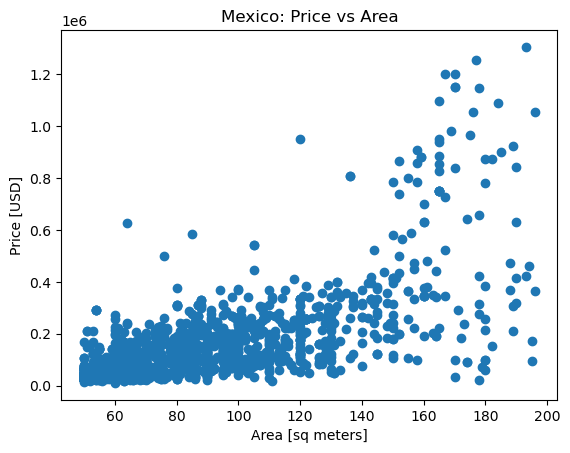

In [8]:
# Create a scatter plot

plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico: Price vs Area");

In [9]:
# Create the feature matrix named X_train

features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(2107, 1)

In [10]:
#Create the target vector named y_train

target = "price_aprox_usd"
y_train = df[target]
y_train.head()

2     52686.48
3     48581.99
6     60589.45
8     33530.62
11    23355.39
Name: price_aprox_usd, dtype: float64

# Build Model

## Baseline

In [11]:
# Calculate the mean of your target vector y_train and assign it to the variable y_mean

y_mean =y_train.mean()
y_mean

134165.9443663977

In [12]:
# Create a list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y

y_pred_baseline = [y_mean]*len(y_train)
y_pred_baseline[:5]

[134165.9443663977,
 134165.9443663977,
 134165.9443663977,
 134165.9443663977,
 134165.9443663977]

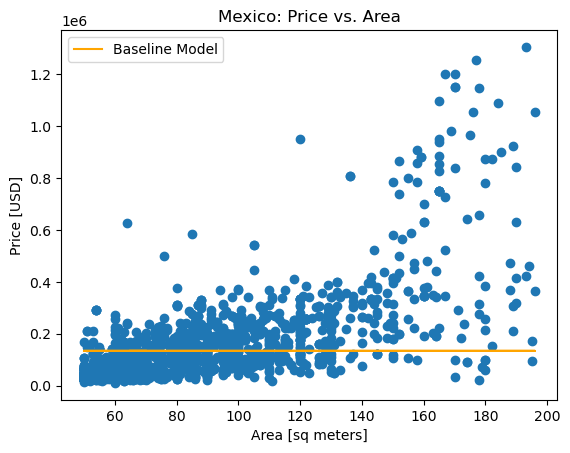

In [13]:
# Add a line to the plot that shows the relationship between the observations X_train and our dumb model's predictions y_pred_baseline.

plt.plot(X_train.values, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico: Price vs. Area")
plt.legend();

Looking at this visualization, it seems like the baseline module does not really follow the trend

In [14]:
# Calculate the baseline mean absolute error for your predictions in y_pred_baseline as compared to the true targets in y

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
ascii
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

# If we always predicted that an apartment price is $134,165.94, our predictions would be off by an average of $41 843,75. 
# It also tells us that our model needs to have mean absolute error below $44,220.96 in order to be useful.

Mean apt price 134165.94
Baseline MAE: 92322.19


In [15]:
# Instantiate a LinearRegression model named model.
model = LinearRegression()

In [16]:
# Fit your model to the data, X_train and y_train.

model.fit(X_train, y_train)

LinearRegression()

## Evaluate

In [17]:
#Create a list of predictions for the observations in your feature matrix X_train. Name this array y_pred_training.

y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([68028.09734882, 71443.26359885, 23630.93609849, 81688.76234892,
       30461.26859854])

In [18]:
# Calculate your training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train

mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 65222.67


In [19]:
# Extract the intercept from the model

intercept = round(model.intercept_,2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: -153957.71


In [20]:
# Extract the coefficient associated "surface_covered_in_m2"

coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 3415.17


In [21]:
# Print the equation that the model has determined for predicting apartment price based on size

print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = -153957.71 + 3415.17 * surface_covered


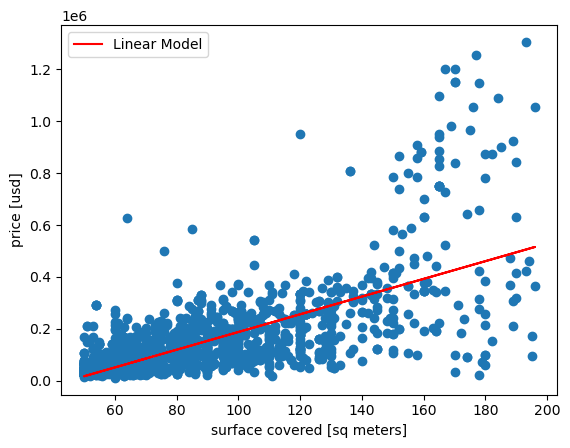

In [22]:
# Add a line to the plot that shows the relationship between the observations in X_train and your model's predictions y_pred_training

plt.plot(X_train, model.predict(X_train), color="r", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();